In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Dropout,LSTM, Input
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from time import time
from keras.layers import LeakyReLU, PReLU
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
df=pd.read_csv(r"/content/drive/MyDrive/sleep_prediction.csv")
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,277,Male,49,Doctor,8.1,9,85,3,Obese,139/91,86,3700,Sleep Apnea
1,40,Male,31,Doctor,7.6,7,75,6,Normal,120/80,70,8000,NaN
2,74,Male,33,Doctor,6.1,6,30,8,Normal,125/80,72,5000,NaN
3,287,Female,50,Nurse,6.0,6,90,8,Overweight,140/95,75,10000,Sleep Apnea
4,171,Male,41,Lawyer,7.7,8,90,5,Normal,130/85,70,8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,Male,31,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
996,348,Female,57,Nurse,8.2,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
997,231,Female,44,Teacher,6.6,7,45,4,Overweight,135/90,65,6000,Insomnia
998,186,Female,42,Teacher,6.8,6,45,7,Overweight,130/85,78,5000,Sleep Apnea


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                1000 non-null   int64  
 1   Gender                   1000 non-null   object 
 2   Age                      1000 non-null   int64  
 3   Occupation               1000 non-null   object 
 4   Sleep Duration           1000 non-null   float64
 5   Quality of Sleep         1000 non-null   int64  
 6   Physical Activity Level  1000 non-null   int64  
 7   Stress Level             1000 non-null   int64  
 8   BMI Category             1000 non-null   object 
 9   Blood Pressure           1000 non-null   object 
 10  Heart Rate               1000 non-null   int64  
 11  Daily Steps              1000 non-null   int64  
 12  Sleep Disorder           413 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 101.7+ KB


In [46]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.0000,1000.000000
mean,193.407000,42.659000,7.152900,7.34000,59.430000,5.346000,70.2010,6840.100000
std,108.225941,8.762163,0.805593,1.23285,21.201288,1.793181,4.1233,1615.230931
min,1.000000,27.000000,5.800000,4.00000,30.000000,3.000000,65.0000,3000.000000
25%,103.000000,36.000000,6.500000,6.00000,45.000000,4.000000,68.0000,5600.000000
50%,195.000000,43.000000,7.200000,7.00000,60.000000,5.000000,70.0000,7000.000000
75%,288.000000,50.000000,7.800000,8.00000,75.000000,7.000000,72.0000,8000.000000
max,373.000000,59.000000,8.500000,9.00000,90.000000,8.000000,86.0000,10000.000000


In [47]:
df.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [48]:
df['Sleep Disorder'].fillna('None', inplace=True)

<ipython-input-48-baf0d52f98af>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sleep Disorder'].fillna('None', inplace=True)


In [49]:
df["Sleep Disorder"].unique()

array(['Sleep Apnea', 'None', 'Insomnia'], dtype=object)

In [50]:
df = df.drop(columns=["Person ID"])

In [51]:
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,49,Doctor,8.1,9,85,3,Obese,139/91,86,3700,Sleep Apnea
1,Male,31,Doctor,7.6,7,75,6,Normal,120/80,70,8000,None
2,Male,33,Doctor,6.1,6,30,8,Normal,125/80,72,5000,None
3,Female,50,Nurse,6.0,6,90,8,Overweight,140/95,75,10000,Sleep Apnea
4,Male,41,Lawyer,7.7,8,90,5,Normal,130/85,70,8000,None
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Male,31,Doctor,7.8,7,75,6,Normal,120/80,70,8000,None
996,Female,57,Nurse,8.2,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
997,Female,44,Teacher,6.6,7,45,4,Overweight,135/90,65,6000,Insomnia
998,Female,42,Teacher,6.8,6,45,7,Overweight,130/85,78,5000,Sleep Apnea


In [52]:
df.shape

(1000, 12)

In [53]:
df["Gender"].unique()

array(['Male', 'Female'], dtype=object)

In [54]:
df["Occupation"].unique()

array(['Doctor', 'Nurse', 'Lawyer', 'Salesperson', 'Engineer',
       'Scientist', 'Manager', 'Accountant', 'Software Engineer',
       'Teacher', 'Sales Representative'], dtype=object)

In [55]:
df["Sleep Duration"].unique()

array([8.1, 7.6, 6.1, 6. , 7.7, 8.2, 6.5, 7.8, 6.2, 6.4, 7.4, 6.3, 7.2,
       8.3, 6.9, 8. , 7.1, 5.9, 6.6, 7.3, 8.5, 7.5, 6.8, 8.4, 6.7, 7.9,
       5.8])

In [56]:
df["BMI Category"].unique()

array(['Obese', 'Normal', 'Overweight', 'Normal Weight'], dtype=object)

In [57]:
df['Gender'] = df['Gender'].astype('category').cat.codes

In [58]:
df['Gender'] = df['Gender'].astype('category').cat.codes
df['Age'] = df['Age'].astype('category').cat.codes
df['Occupation'] = df['Occupation'].astype('category').cat.codes
df['BMI Category'] = df['BMI Category'].astype('category').cat.codes
df['Blood Pressure'] = df['Blood Pressure'].astype('category').cat.codes
df['Sleep Disorder'] = df['Sleep Disorder'].astype('category').cat.codes

In [59]:
df.corr()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Gender,1.000000,-0.573286,-0.213156,-0.143291,-0.294277,0.001336,0.402557,-0.334469,-0.174298,0.208931,0.008115,-0.303288
Age,-0.573286,1.000000,0.234119,0.394585,0.509758,0.197022,-0.464260,0.487035,0.561980,-0.273029,0.044340,0.254150
Occupation,-0.213156,0.234119,1.000000,-0.350710,-0.304057,-0.105405,0.056916,0.705741,0.549888,0.081050,-0.126065,-0.144465
Sleep Duration,-0.143291,0.394585,-0.350710,1.000000,0.893700,0.195525,-0.827509,-0.377724,-0.172554,-0.544432,-0.059605,0.169350
Quality of Sleep,-0.294277,0.509758,-0.304057,0.893700,1.000000,0.196493,-0.903160,-0.317372,-0.132931,-0.676471,0.018130,0.194816
Physical Activity Level,0.001336,0.197022,-0.105405,0.195525,0.196493,1.000000,-0.031616,0.084271,0.301661,0.134471,0.770584,0.414200
Stress Level,0.402557,-0.464260,0.056916,-0.827509,-0.903160,-0.031616,1.000000,0.176190,0.114190,0.673594,0.189709,-0.058087
BMI Category,-0.334469,0.487035,0.705741,-0.377724,-0.317372,0.084271,0.176190,1.000000,0.712389,0.318444,-0.017528,0.067378
Blood Pressure,-0.174298,0.561980,0.549888,-0.172554,-0.132931,0.301661,0.114190,0.712389,1.000000,0.288857,0.132525,0.236246
Heart Rate,0.208931,-0.273029,0.081050,-0.544432,-0.676471,0.134471,0.673594,0.318444,0.288857,1.000000,-0.035780,0.176985


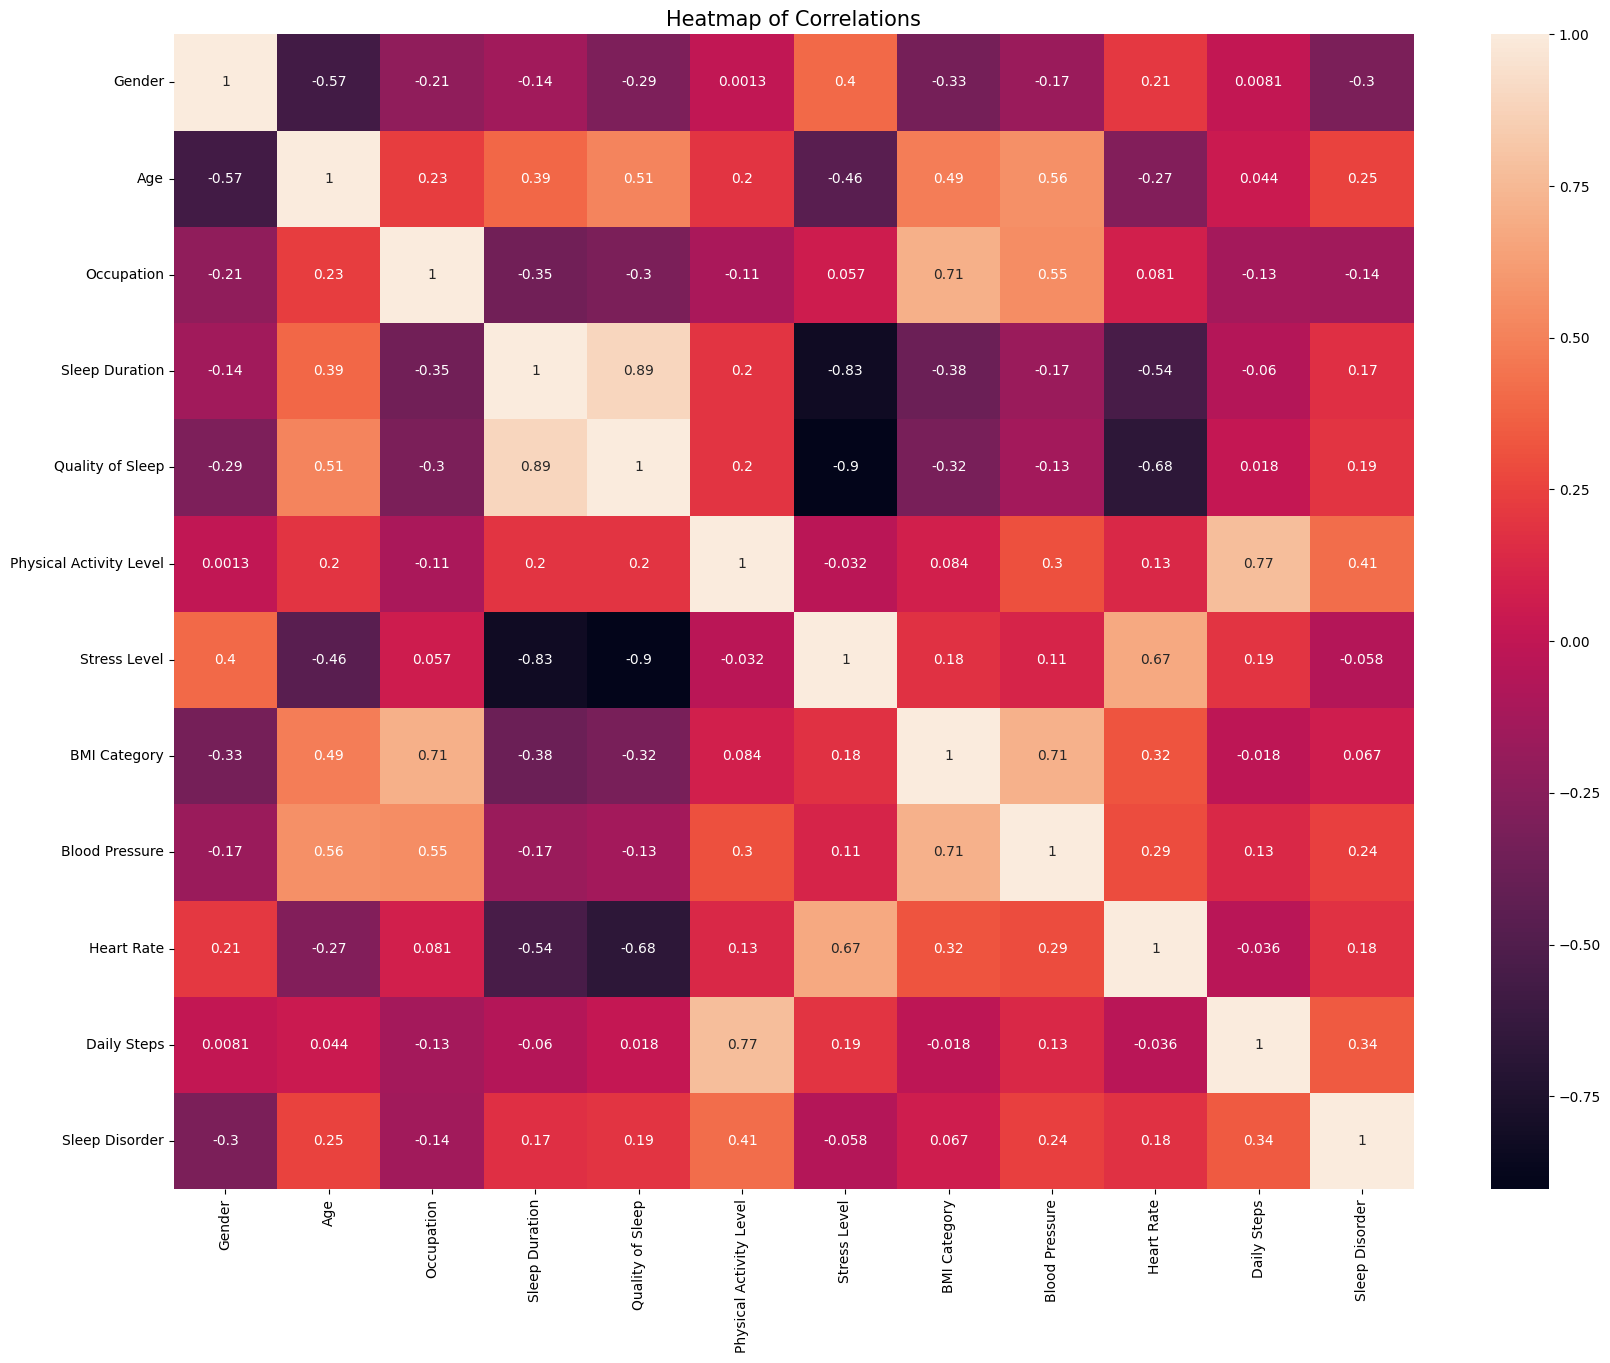

In [60]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True)
plt.title('Heatmap of Correlations',fontsize=15)
plt.show()

In [61]:
df["Gender"].value_counts()

,count
Gender,
0,505
1,495


In [62]:
df["Occupation"].value_counts()

,count
Occupation,
5,206
2,179
1,175
3,129
10,99
0,92
7,89
8,15
9,8


In [63]:
df["BMI Category"].value_counts()

,count
BMI Category,
0,514
3,412
1,51
2,23


In [64]:
df["Sleep Disorder"].value_counts()

,count
Sleep Disorder,
1,587
2,215
0,198


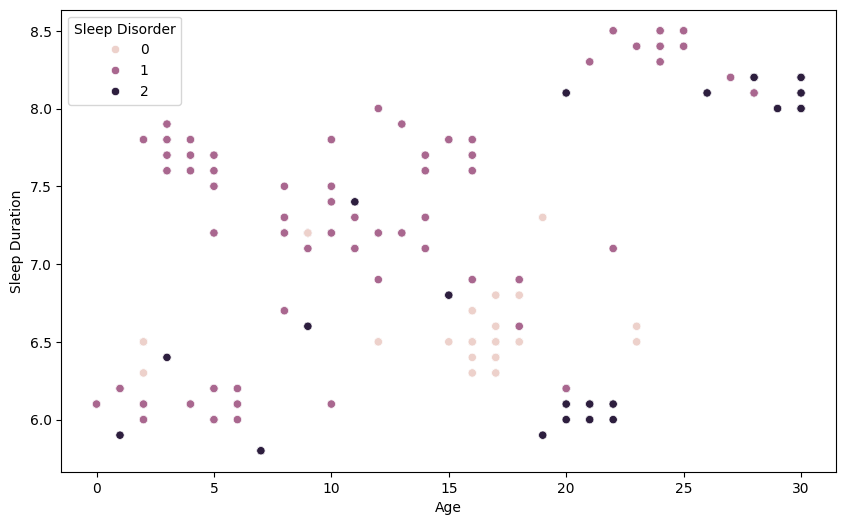

In [65]:
plt.figure(figsize=(10,6),dpi=100)
sns.despine(left=True)
sns.scatterplot(x='Age', y='Sleep Duration', hue = 'Sleep Disorder', data=df)
plt.show()

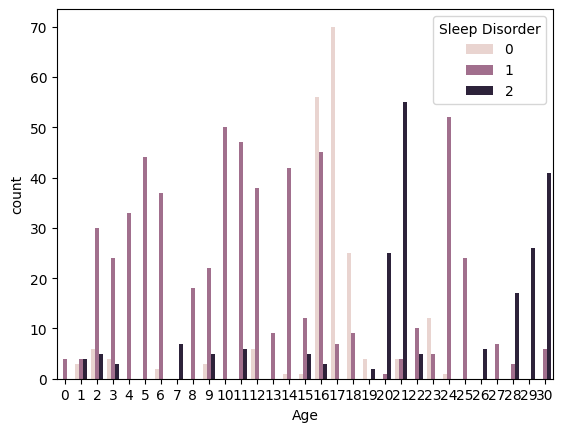

In [66]:
sns.countplot(x=df["Age"],hue=df['Sleep Disorder'])
plt.show()

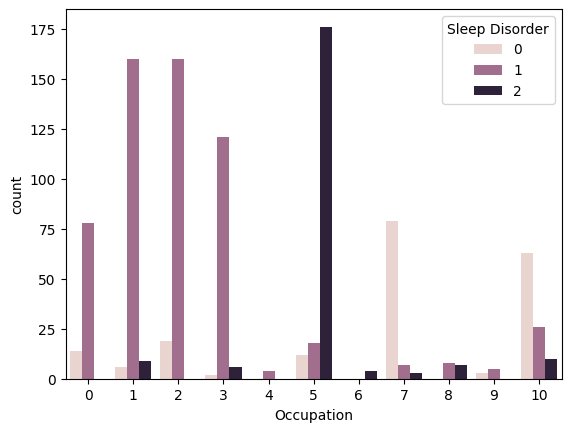

In [67]:
sns.countplot(x=df["Occupation"],hue=df['Sleep Disorder'])
plt.show()

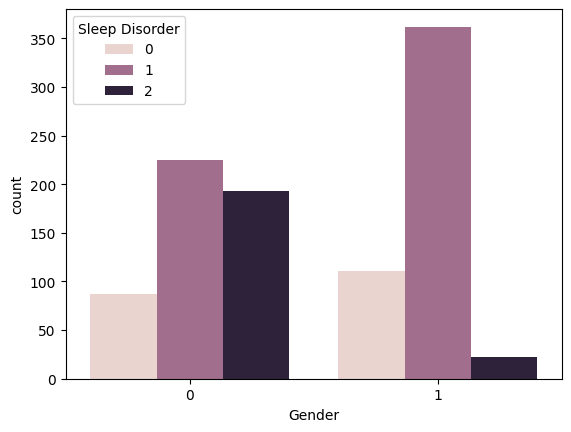

In [68]:
sns.countplot(x=df["Gender"],hue=df['Sleep Disorder'])
plt.show()

In [69]:
df.columns.to_list()

['Gender',
 'Age',
 'Occupation',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'BMI Category',
 'Blood Pressure',
 'Heart Rate',
 'Daily Steps',
 'Sleep Disorder']

In [70]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [71]:
df['Gender']=le.fit_transform(df['Gender'])
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,20,1,8.1,9,85,3,2,21,86,3700,2
1,1,4,1,7.6,7,75,6,0,6,70,8000,1
2,1,6,1,6.1,6,30,8,0,9,72,5000,1
3,0,21,5,6.0,6,90,8,3,23,75,10000,2
4,1,14,3,7.7,8,90,5,0,15,70,8000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,1,7.8,7,75,6,0,6,70,8000,1
996,0,28,5,8.2,9,75,3,3,23,68,7000,2
997,0,17,10,6.6,7,45,4,3,20,65,6000,0
998,0,15,10,6.8,6,45,7,3,15,78,5000,2


In [72]:
df['Occupation']=le.fit_transform(df['Occupation'])
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,20,1,8.1,9,85,3,2,21,86,3700,2
1,1,4,1,7.6,7,75,6,0,6,70,8000,1
2,1,6,1,6.1,6,30,8,0,9,72,5000,1
3,0,21,5,6.0,6,90,8,3,23,75,10000,2
4,1,14,3,7.7,8,90,5,0,15,70,8000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,1,7.8,7,75,6,0,6,70,8000,1
996,0,28,5,8.2,9,75,3,3,23,68,7000,2
997,0,17,10,6.6,7,45,4,3,20,65,6000,0
998,0,15,10,6.8,6,45,7,3,15,78,5000,2


In [73]:
df['BMI Category']=le.fit_transform(df['BMI Category'])
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,20,1,8.1,9,85,3,2,21,86,3700,2
1,1,4,1,7.6,7,75,6,0,6,70,8000,1
2,1,6,1,6.1,6,30,8,0,9,72,5000,1
3,0,21,5,6.0,6,90,8,3,23,75,10000,2
4,1,14,3,7.7,8,90,5,0,15,70,8000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,1,7.8,7,75,6,0,6,70,8000,1
996,0,28,5,8.2,9,75,3,3,23,68,7000,2
997,0,17,10,6.6,7,45,4,3,20,65,6000,0
998,0,15,10,6.8,6,45,7,3,15,78,5000,2


In [74]:


df['Sleep Disorder']=le.fit_transform(df['Sleep Disorder'])
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,20,1,8.1,9,85,3,2,21,86,3700,2
1,1,4,1,7.6,7,75,6,0,6,70,8000,1
2,1,6,1,6.1,6,30,8,0,9,72,5000,1
3,0,21,5,6.0,6,90,8,3,23,75,10000,2
4,1,14,3,7.7,8,90,5,0,15,70,8000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,1,7.8,7,75,6,0,6,70,8000,1
996,0,28,5,8.2,9,75,3,3,23,68,7000,2
997,0,17,10,6.6,7,45,4,3,20,65,6000,0
998,0,15,10,6.8,6,45,7,3,15,78,5000,2


In [75]:
df['Blood Pressure']=le.fit_transform(df['Blood Pressure'])
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,20,1,8.1,9,85,3,2,21,86,3700,2
1,1,4,1,7.6,7,75,6,0,6,70,8000,1
2,1,6,1,6.1,6,30,8,0,9,72,5000,1
3,0,21,5,6.0,6,90,8,3,23,75,10000,2
4,1,14,3,7.7,8,90,5,0,15,70,8000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,4,1,7.8,7,75,6,0,6,70,8000,1
996,0,28,5,8.2,9,75,3,3,23,68,7000,2
997,0,17,10,6.6,7,45,4,3,20,65,6000,0
998,0,15,10,6.8,6,45,7,3,15,78,5000,2


In [76]:
df["Sleep Disorder"].value_counts()

,count
Sleep Disorder,
1,587
2,215
0,198


In [77]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df['Sleep Disorder']== 1]
df_minority = df[df['Sleep Disorder']== 2]
df_minority1 = df[df['Sleep Disorder']== 0]

# Downsample majority class and upsample the minority class
df_minority_upsampled = resample(df_minority, replace=True,n_samples=300,random_state=100)
df_minority1_upsampled = resample(df_minority1, replace=True,n_samples=300,random_state=100)
df_majority_downsampled = resample(df_majority, replace=True,n_samples=300,random_state=100)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority_upsampled,df_minority1_upsampled,df_majority_downsampled])

# Display new class counts
df_balanced['Sleep Disorder'].value_counts()

,count
Sleep Disorder,
2,300
0,300
1,300


In [78]:

df=df_balanced
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
24,0,3,5,6.4,5,35,7,1,16,78,4100,2
110,0,21,5,6.0,6,90,8,3,23,75,10000,2
358,0,21,5,6.1,6,90,8,3,23,75,10000,2
514,0,20,5,6.1,6,90,8,3,23,75,10000,2
462,0,21,5,6.0,6,90,8,3,23,75,10000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,4,1,7.7,7,75,6,0,6,70,8000,1
557,1,6,1,6.1,6,30,8,0,9,72,5000,1
35,1,8,2,7.2,8,60,4,0,9,65,5000,1
933,0,24,2,8.4,9,30,3,0,9,65,5000,1


In [79]:
x = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

In [80]:
import pickle
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=100)

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# Save the scaler as a .pkl file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("StandardScaler saved successfully!")

StandardScaler saved successfully!


In [81]:
x_train.shape, y_train.shape

((675, 11), (675,))

In [82]:
x_test.shape, y_test.shape

((225, 11), (225,))

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [84]:
from sklearn.ensemble import RandomForestClassifier

dept = [1, 5, 10, 50, 100, 500, 1000]
n_estimators =  [20, 40, 60, 80, 100, 120]

param_grid={'n_estimators':n_estimators , 'max_depth':dept}
clf = RandomForestClassifier()
model = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=5)
model.fit(x_train,y_train)
print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)
optimal_max_depth = model.best_estimator_.max_depth
optimal_n_estimators = model.best_estimator_.n_estimators

optimal n_estimators 120
optimal max_depth 5


Accuracy for Test data is 0.9422222222222222
Accuracy for Train data is 0.9362962962962963
---------------------------


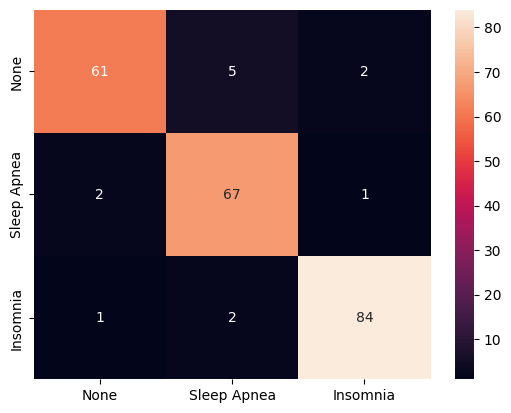

In [85]:
from sklearn.metrics import accuracy_score
#training our model for max_depth=500,n_estimators = 60
clf = RandomForestClassifier(max_depth = optimal_max_depth,n_estimators = optimal_n_estimators)
clf.fit(x_train,y_train)

pred_test3 =clf.predict(x_test)
test_accuracy3 = accuracy_score(y_test, pred_test3)
pred_train = clf.predict(x_train)
train_accuracy3 =accuracy_score(y_train,pred_train)


print("Accuracy for Test data is " +str(accuracy_score(y_test,pred_test3)))
print("Accuracy for Train data is " +str(accuracy_score(y_train,pred_train)))

print("---------------------------")

import pickle
filename = r'rf.pkl'
pickle.dump(clf, open(filename, 'wb'))

# Code for drawing seaborn heatmaps
class_names =['None','Sleep Apnea','Insomnia']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred_test3.round()), index=class_names, columns=class_names )
fig = plt.figure( )
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [86]:
from sklearn.metrics import accuracy_score, classification_report
class_names = ['None', 'Sleep Apnea', 'Insomnia']
print("Classification Report:")
print(classification_report(y_test, pred_test3, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        None       0.95      0.90      0.92        68
 Sleep Apnea       0.91      0.96      0.93        70
    Insomnia       0.97      0.97      0.97        87

    accuracy                           0.94       225
   macro avg       0.94      0.94      0.94       225
weighted avg       0.94      0.94      0.94       225



Accuracy on Train data is 0.9362962962962963
Accuracy on Test data is 0.9333333333333333
---------------------------


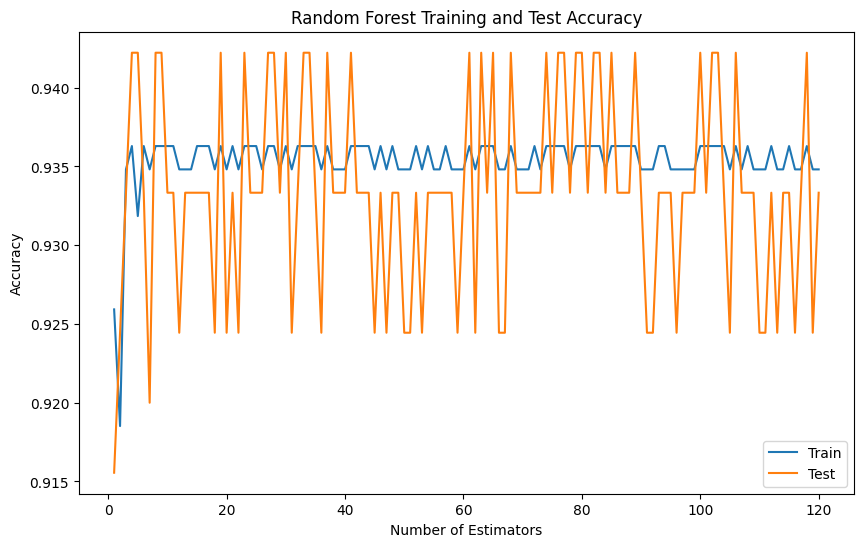

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Training the Random Forest classifier
clf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=optimal_n_estimators)
clf.fit(x_train, y_train)

# Predictions on train and test sets
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("Accuracy on Train data is " + str(train_accuracy))
print("Accuracy on Test data is " + str(test_accuracy))
print("---------------------------")

# Training and test accuracy curves
train_accuracies = []
test_accuracies = []
estimators_range = range(1, optimal_n_estimators + 1)  # Adjust range if necessary

for n_estimators in estimators_range:
    clf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=n_estimators)
    clf.fit(x_train, y_train)

    train_pred = clf.predict(x_train)
    test_pred = clf.predict(x_test)

    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting the training and test accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, train_accuracies, label='Train')
plt.plot(estimators_range, test_accuracies, label='Test')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Training and Test Accuracy')
plt.legend()
plt.show()


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, Dropout,LSTM, Input
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from time import time
from keras.layers import LeakyReLU, PReLU
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

In [90]:
from keras.utils import to_categorical

# Convert integer labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model1 = Sequential()
model1.add(Dense(100, activation='relu', input_dim=11))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,003 (54.70 KB)

 Trainable params: 14,003 (54.70 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
History = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=200, verbose=2)

Epoch 1/50
4/4 - 9s - 2s/step - accuracy: 0.3467 - loss: 1.2011 - val_accuracy: 0.6711 - val_loss: 1.0328
Epoch 2/50
4/4 - 4s - 892ms/step - accuracy: 0.4874 - loss: 1.0265 - val_accuracy: 0.8800 - val_loss: 0.8659
Epoch 3/50
4/4 - 0s - 19ms/step - accuracy: 0.5689 - loss: 0.8746 - val_accuracy: 0.9067 - val_loss: 0.4901
Epoch 4/50
4/4 - 0s - 20ms/step - accuracy: 0.7348 - loss: 0.7208 - val_accuracy: 0.8844 - val_loss: 0.3819
Epoch 5/50
4/4 - 0s - 37ms/step - accuracy: 0.7941 - loss: 0.6493 - val_accuracy: 0.9111 - val_loss: 0.3789
Epoch 6/50
4/4 - 0s - 32ms/step - accuracy: 0.8281 - loss: 0.6276 - val_accuracy: 0.9244 - val_loss: 0.3611
Epoch 7/50
4/4 - 0s - 33ms/step - accuracy: 0.8622 - loss: 0.5210 - val_accuracy: 0.9244 - val_loss: 0.3555
Epoch 8/50
4/4 - 0s - 34ms/step - accuracy: 0.8622 - loss: 0.4886 - val_accuracy: 0.9156 - val_loss: 0.3597
Epoch 9/50
4/4 - 0s - 34ms/step - accuracy: 0.8770 - loss: 0.4747 - val_accuracy: 0.9156 - val_loss: 0.3549
Epoch 10/50
4/4 - 0s - 19ms/s

In [93]:
# print the test accuracy
score = model1.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', score[1])

8/8 - 1s - 98ms/step - accuracy: 0.9244 - loss: 0.3896
Test accuracy: 0.9244444370269775


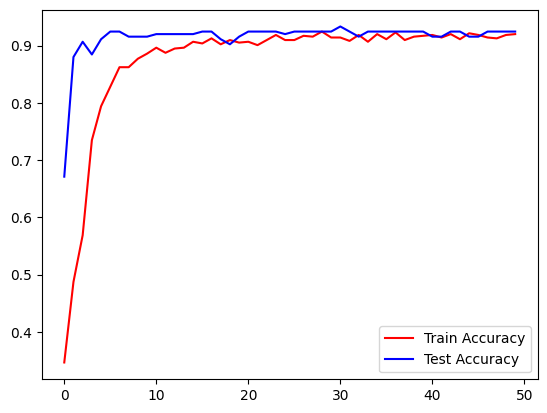

In [94]:
# plot the accuracy plot
plt.plot(History.history['accuracy'], 'r')
plt.plot(History.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

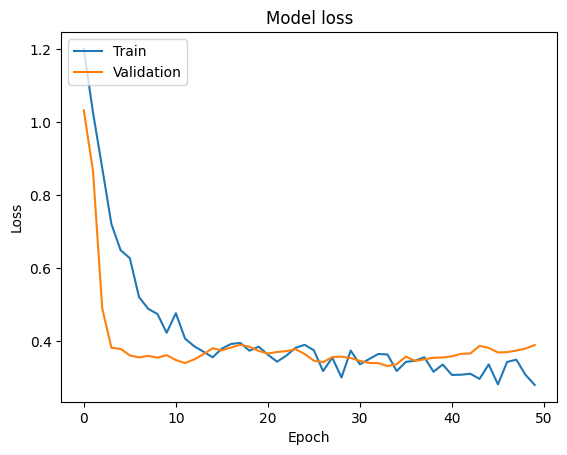

In [95]:
# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [96]:
from sklearn.metrics import classification_report
import numpy as np
y_pred_prob = model1.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)

class_names = ['None', 'Sleep Apnea', 'Insomnia']  # Update with your class names
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
              precision    recall  f1-score   support

        None       0.97      0.82      0.89        68
 Sleep Apnea       0.91      0.96      0.93        70
    Insomnia       0.91      0.98      0.94        87

    accuracy                           0.92       225
   macro avg       0.93      0.92      0.92       225
weighted avg       0.93      0.92      0.92       225



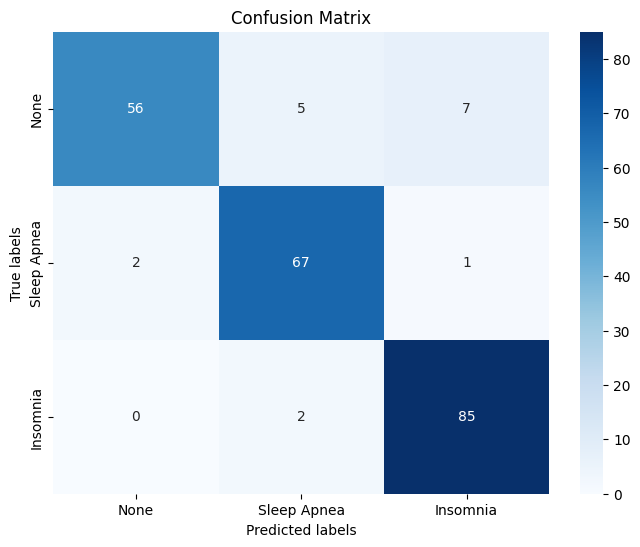

In [97]:
# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


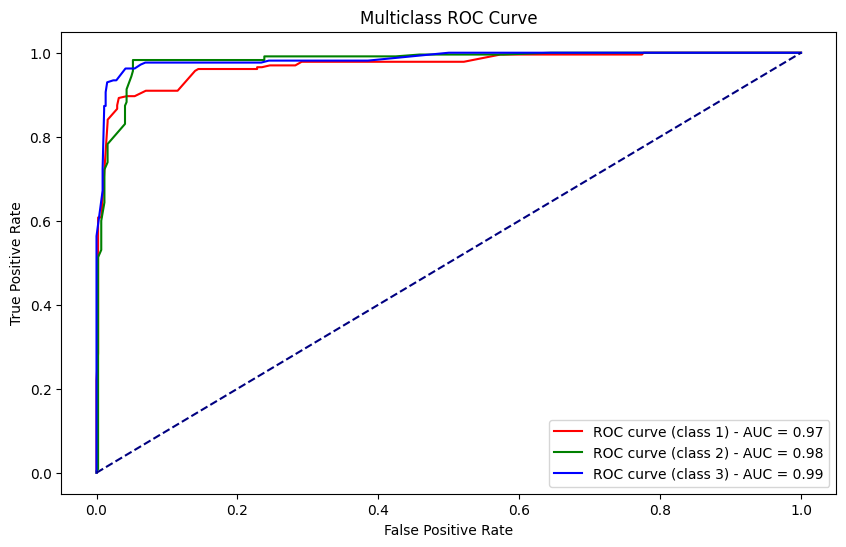

In [98]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Get predicted probabilities for each class
train_pred_prob = model1.predict(x_train)
test_pred_prob = model1.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], train_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve (class {i+1}) - AUC = {roc_auc[i]:.2f}')

# Plot baseline
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
from tensorflow.keras.layers import Flatten

In [100]:
model = Sequential()
model.add(Input(shape=(11,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16,return_sequences=True))
model.add(LSTM(8))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 11, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 11, 16)              │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 250)                 │           2,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,291 (415.20 KB)

 Trainable params: 106,291 (415.20 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
History_1 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, batch_size=28, verbose=2)

Epoch 1/50
25/25 - 6s - 226ms/step - accuracy: 0.5185 - loss: 0.6466 - val_accuracy: 0.5600 - val_loss: 0.5679
Epoch 2/50
25/25 - 0s - 12ms/step - accuracy: 0.6696 - loss: 0.4810 - val_accuracy: 0.8044 - val_loss: 0.3723
Epoch 3/50
25/25 - 0s - 12ms/step - accuracy: 0.8030 - loss: 0.3522 - val_accuracy: 0.8667 - val_loss: 0.2935
Epoch 4/50
25/25 - 0s - 12ms/step - accuracy: 0.8385 - loss: 0.3056 - val_accuracy: 0.8578 - val_loss: 0.2683
Epoch 5/50
25/25 - 0s - 13ms/step - accuracy: 0.8459 - loss: 0.2908 - val_accuracy: 0.8667 - val_loss: 0.2474
Epoch 6/50
25/25 - 1s - 23ms/step - accuracy: 0.8489 - loss: 0.2762 - val_accuracy: 0.8711 - val_loss: 0.2358
Epoch 7/50
25/25 - 0s - 13ms/step - accuracy: 0.8859 - loss: 0.2438 - val_accuracy: 0.8756 - val_loss: 0.2123
Epoch 8/50
25/25 - 0s - 12ms/step - accuracy: 0.8830 - loss: 0.2431 - val_accuracy: 0.9111 - val_loss: 0.2169
Epoch 9/50
25/25 - 0s - 12ms/step - accuracy: 0.8830 - loss: 0.2355 - val_accuracy: 0.9022 - val_loss: 0.1900
Epoch 10/

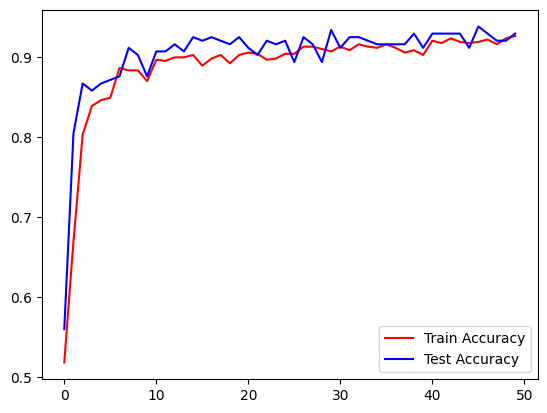

In [102]:
# plot the accuracy plot
plt.plot(History_1.history['accuracy'], 'r')
plt.plot(History_1.history['val_accuracy'], 'b')
plt.legend({'Train Accuracy': 'r', 'Test Accuracy':'b'})
plt.show()

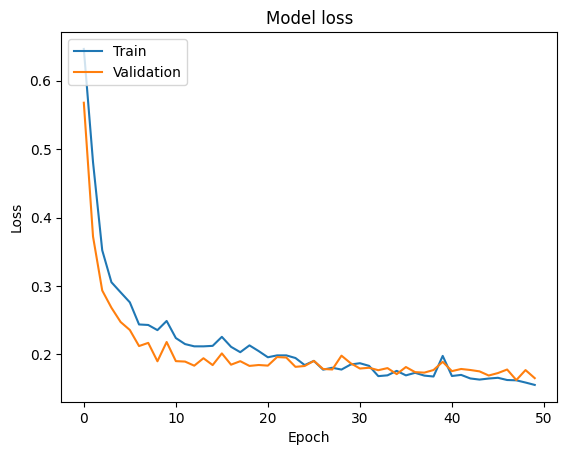

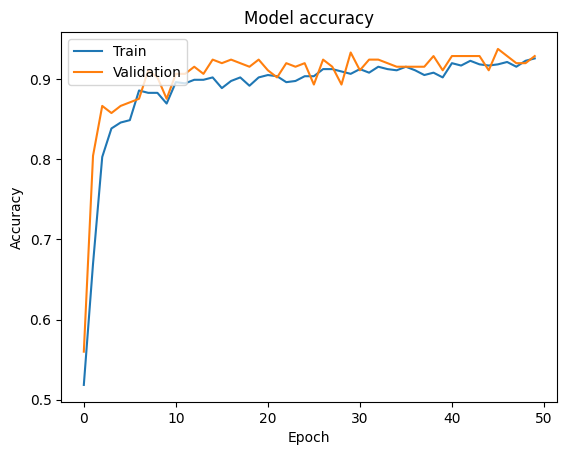

In [103]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(History_1.history['loss'])
plt.plot(History_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(History_1.history['accuracy'])
plt.plot(History_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

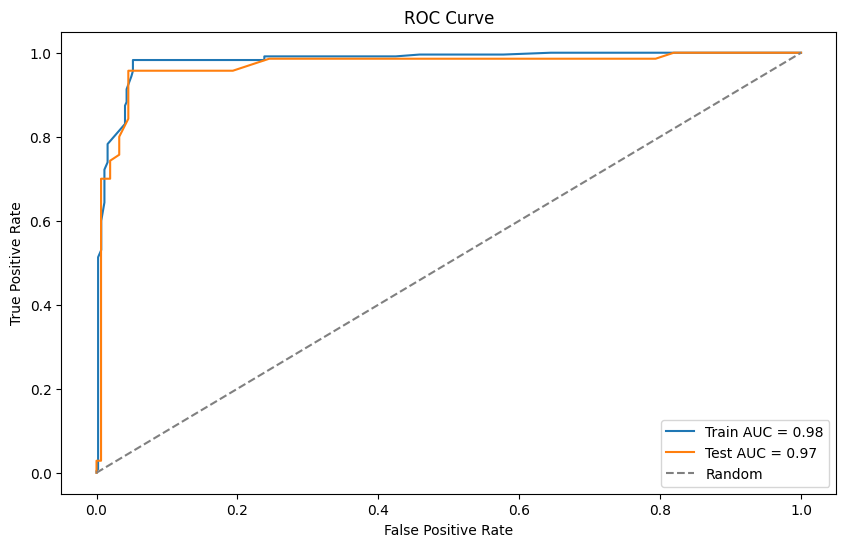

In [104]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

train_fpr, train_tpr, _ = roc_curve(y_train_bin[:, 1], train_pred_prob[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test_bin[:, 1], test_pred_prob[:, 1])

train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.2f}')
plt.plot(test_fpr, test_tpr, label=f'Test AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [105]:
y_pred_prob = model.predict(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)

class_names = ['None', 'Sleep Apnea', 'Insomnia']  # Update with your class names
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
              precision    recall  f1-score   support

        None       0.90      0.91      0.91        68
 Sleep Apnea       0.90      0.94      0.92        70
    Insomnia       0.98      0.93      0.95        87

    accuracy                           0.93       225
   macro avg       0.93      0.93      0.93       225
weighted avg       0.93      0.93      0.93       225



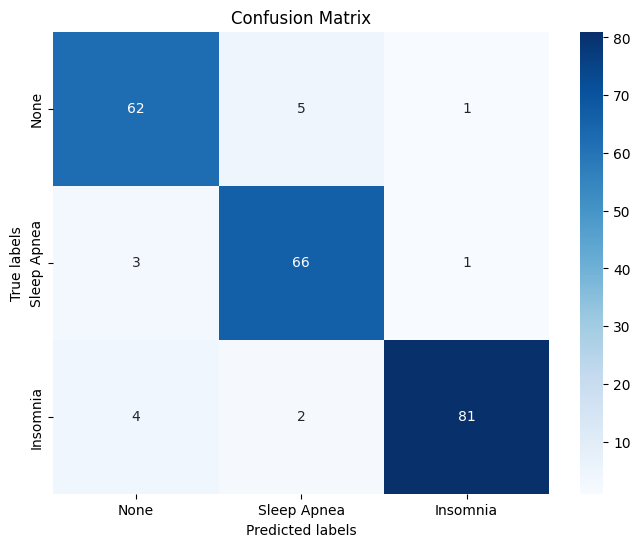

In [106]:
# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [107]:
import pickle
filename = r'RF_Sleep.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [108]:
import pickle
filename = r'CNN_Sleep.pkl'
pickle.dump(model1, open(filename, 'wb'))

In [109]:
import pickle
filename = r'LSTM_Sleep.pkl'
pickle.dump(model, open(filename, 'wb'))

In [79]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [110]:
import numpy as np
import sklearn
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)


NumPy version: 2.0.2
Scikit-learn version: 1.6.1
